In [1]:
from cmb.configs.experiments import Configs
from cmb.data.jetclass import CouplingData
from cmb.dynamics.cfm import ConditionalFlowMatching

config = Configs('epic.yaml')
jets = CouplingData(config=config.data, standardize=False)
dynamics = ConditionalFlowMatching(config.dynamics)

config.print()

2024-09-20 00:10:21.330921: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 00:10:21.374352: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 00:10:21.375304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 00:10:22.174173: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


general:
    workdir: ../../results
    experiment_name: beta_to_tops_ConditionalFlowMatching_EPiC_2024.09.20_00h10
data:
    dataset: JetClass
    target:
        name: tops
        num_jets: None
        path: ['/home/df630/CMB/data/JetClass/TTBar_000.root']
    source:
        name: beta
        concentration: [0.1, 10.0]
        num_jets: None
        path: None
    min_num_particles: 0
    max_num_particles: 128
    dim:
        features:
            continuous: 3
            discrete: 0
            vocab_size: 0
        context:
            continuous: 0
            discrete: 0
            vocab_size: 0
model:
    name: EPiC
    num_blocks: 8
    dim:
        emb:
            time: 16
            features:
                continuous: 0
                discrete: 0
            context:
                continuous: 0
                discrete: 0
        hidden:
            local: 256
            glob: 10
    embed_type:
        time: sinusoidal
        features:
            continuous

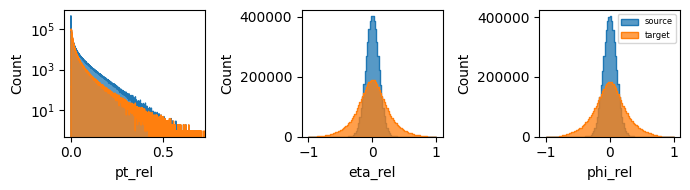

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2))
jets.source.histplot('pt_rel', ax=ax[0], log_scale=(False,True))
jets.target.histplot('pt_rel', ax=ax[0], log_scale=(False,True))
jets.source.histplot('eta_rel', binrange=(-1,1), binwidth=0.02, ax=ax[1])
jets.target.histplot('eta_rel', binrange=(-1,1), binwidth=0.02,ax=ax[1])
jets.source.histplot('phi_rel', binrange=(-1,1), binwidth=0.02,ax=ax[2], label='source')
jets.target.histplot('phi_rel',binrange=(-1,1), binwidth=0.02, ax=ax[2], label='target')
ax[2].legend(fontsize=6)
plt.tight_layout()
plt.show()

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.nn.utils.weight_norm as weight_norm
from torch.nn.functional import softmax

from cmb.models.architectures.utils import KANLinear, SinusoidalPositionalEncoding 


class MixedDataEPiC(nn.Module):
    ''' model wrapper EPiC network for continuous/discrete data 
    '''
    def __init__(self, config):
        super().__init__()

        self.device = config.train.device

        #...input dimensions:
        self.dim_features_continuous = config.data.dim.features.continuous  
        self.dim_features_discrete = config.data.dim.features.discrete
        dim_context_continuous = config.data.dim.context.continuous 
        dim_context_discrete = config.data.dim.context.discrete     
        self.vocab_size = config.data.dim.features.vocab_size           
        vocab_size_context = config.data.dim.context.vocab_size             

        #...embedding dimensions:
        dim_time_emb = config.model.dim.emb.time
        dim_features_continuous_emb = config.model.dim.emb.features.continuous if config.model.dim.emb.features.continuous else self.dim_features_continuous
        dim_features_discrete_emb = config.model.dim.emb.features.discrete
        dim_context_continuous_emb = config.model.dim.emb.context.continuous if config.model.dim.emb.context.continuous else dim_context_continuous
        dim_context_discrete_emb = config.model.dim.emb.context.discrete
        
        #...hidden dimensions:
        dim_hidden_local = config.model.dim.hidden.local
        dim_hidden_global = config.model.dim.hidden.glob

        #...other model params:
        self.num_blocks = config.model.num_blocks
        self.use_skip_connection = config.model.skip_connection

        #...components:

        self.embedding = InputEmbedding(dim_features_continuous=self.dim_features_continuous,
                                        dim_features_discrete=self.dim_features_discrete,
                                        dim_context_continuous=dim_context_continuous,
                                        dim_context_discrete=dim_context_discrete,
                                        vocab_size=self.vocab_size,      
                                        vocab_size_context=vocab_size_context,
                                        dim_time_emb=dim_time_emb,
                                        dim_features_continuous_emb=dim_features_continuous_emb,
                                        dim_context_continuous_emb=dim_context_continuous_emb,
                                        dim_context_discrete_emb=dim_context_discrete_emb,
                                        embed_type_time=config.model.embed_type.time,
                                        embed_type_features_continuous=config.model.embed_type.features.continuous,
                                        embed_type_context_continuous=config.model.embed_type.context.continuous,
                                        embed_type_context_discrete=config.model.embed_type.context.discrete,
                                        )

        self.epic = EPiCNetwork(dim_input=dim_features_continuous_emb + dim_features_discrete_emb + dim_time_emb,
                                dim_output=self.dim_features_continuous,
                                dim_context=dim_context_continuous_emb + dim_context_discrete_emb + dim_time_emb,
                                num_blocks=self.num_blocks,
                                dim_hidden_local=dim_hidden_local,
                                dim_hidden_global=dim_hidden_global,
                                use_skip_connection=self.use_skip_connection)
        
                                                
    def forward(self, t, x, k, context_continuous=None, context_discrete=None, mask=None, output_rates=False):
        ''' Forward pass of the EPiC model
            - t: time input of shape (b, 1)
            - x: continuous features of shape (b, n, dim_continuous)
            - k: discrete features of shape (b,  n, dim_discrete)
            - context: context features of shape (b, dim_context)
            - mask: binary mask of shape (b, n, 1) indicating valid particles (1) or masked particles (0)
        '''

        #...move to device:
        t = t.to(self.device) 
        x = x.to(self.device) 
        context_continuous = context_continuous.to(self.device) if isinstance(context_continuous, torch.Tensor) else None 
        context_discrete = context_discrete.to(self.device) if isinstance(context_discrete, torch.Tensor) else None 
        mask = mask.to(self.device)

        #...particle features and context embeddings:

        x_local_emb, context_emb = self.embedding(t, x, None, context_continuous, context_discrete, mask)

        #...EPiC model:

        h = self.epic(x_local_emb, context_emb, mask)
        continuous_head = h[:, :self.dim_features_continuous]
        discrete_head = h[:, self.dim_features_continuous:]
        logits = discrete_head.reshape(k.size(0), self.dim_features_discrete, self.vocab_size)

        if output_rates: 
            t = t.squeeze()
            t1 = 1. - self.time_epsilon
            beta_integral = (t1 - t) * self.gamma
            wt = torch.exp(-self.vocab_size * beta_integral)
            A = 1.0
            B = (wt * self.vocab_size) / (1. - wt)
            C = wt
            qx = softmax(logits, dim=2)
            qy = torch.gather(qx, 2, k.long().unsqueeze(2))
            rate = A + B[:, None, None] * qx + C[:, None, None] * qy
            return continuous_head, rate
        else:
            return continuous_head, logits


class EPiCNetwork(nn.Module):
    def __init__(self, 
                 dim_input,
                 dim_output=3,
                 dim_context=0,
                 num_blocks=6,
                 dim_hidden_local=128,
                 dim_hidden_global=10,
                 use_skip_connection=False):
        
        super().__init__()
        
        #...model params:
        self.num_blocks = num_blocks
        self.use_skip_connection = use_skip_connection

        #...components:
        self.epic_proj = EPiC_Projection(dim_local=dim_input,
                                         dim_global=dim_context,
                                         dim_hidden_local=dim_hidden_local,
                                         dim_hidden_global=dim_hidden_global)

        self.epic_layers = nn.ModuleList()

        for _ in range(self.num_blocks):
            self.epic_layers.append(EPiC_layer(dim_local=dim_hidden_local, 
                                               dim_global=dim_hidden_global, 
                                               dim_hidden=dim_hidden_local, 
                                               dim_context=dim_context))
            
        #...output layer:

        self.output_layer = weight_norm(nn.Linear(dim_hidden_local, dim_output))
                                                
    def forward(self, x_local, context=None, mask=None):

        #...local to global:

        x_local, x_global = self.epic_proj(x_local, context, mask)

        if self.use_skip_connection:
            x_local_skip = x_local.clone()
            x_global_skip = x_global.clone() 

        #...equivariant layers:
            
        for i in range(self.num_blocks):
            x_local, x_global = self.epic_layers[i](x_local, x_global, context, mask)   
            if self.use_skip_connection:
                x_local += x_local_skip
                x_global += x_global_skip 
    
        #...output layer:

        h = self.output_layer(x_local)
        return h * mask    #[batch, points, feats]


class EPiC_Projection(nn.Module):
    def __init__(self, 
                 dim_local, 
                 dim_global, 
                 dim_hidden_local=128, 
                 dim_hidden_global=10):
        
        super(EPiC_Projection, self).__init__()

        self.local_0 = weight_norm(nn.Linear(dim_local, dim_hidden_local))  # local projection_mlp
        self.global_0 = weight_norm(nn.Linear(2 * dim_hidden_local + dim_global, dim_hidden_local)) # local to global projection_mlp
        self.global_1 = weight_norm(nn.Linear(dim_hidden_local, dim_hidden_local))
        self.global_2 = weight_norm(nn.Linear(dim_hidden_local, dim_hidden_global))

    def meansum_pooling(self, x_local, x_global, mask):
        x_sum = (x_local * mask).sum(1, keepdim=False)
        x_mean = x_sum / mask.sum(1, keepdim=False)
        x_global = torch.cat([x_mean, x_sum, x_global], 1) 
        return x_global

    def forward(self, x_local, x_global, mask):
        x_local = F.leaky_relu(self.local_0(x_local)) 
        x_global = self.meansum_pooling(x_local, x_global, mask)
        x_global = F.leaky_relu(self.global_0(x_global))      
        x_global = F.leaky_relu(self.global_1(x_global))
        x_global = F.leaky_relu(self.global_2(x_global))   
        return x_local * mask, x_global

class EPiC_layer(nn.Module):
    # based on https://github.com/uhh-pd-ml/EPiC-GAN/blob/main/models.py
    def __init__(self, 
                 dim_local, 
                 dim_global, 
                 dim_hidden, 
                 dim_context):
        
        super(EPiC_layer, self).__init__()

        self.fc_global1 = weight_norm(nn.Linear(int(2*dim_local) + dim_global + dim_context, dim_hidden)) 
        self.fc_global2 = weight_norm(nn.Linear(dim_hidden, dim_global)) 
        self.fc_local1 = weight_norm(nn.Linear(dim_local + dim_global + dim_context, dim_hidden))
        self.fc_local2 = weight_norm(nn.Linear(dim_hidden, dim_hidden))

    def forward(self, x_local, x_global, context, mask):   # shapes: x_global.shape=[b, latent], x_local.shape = [b, num_points, latent_local]
        _, num_points, _ = x_local.size()
        dim_global = x_global.size(1)
        dim_context = context.size(1)

        #...meansum pooling
        x_pooled_sum = x_local.sum(1, keepdim=False)
        x_pooled_mean = x_local.mean(1, keepdim=False)
        x_pooled_sum = (x_local * mask).sum(1, keepdim=False)
        x_pooled_mean = x_pooled_sum / mask.sum(1, keepdim=False)
        x_pooledCATglobal = torch.cat([x_pooled_mean, x_pooled_sum, x_global, context], dim=-1)
        x_global1 = F.leaky_relu(self.fc_global1(x_pooledCATglobal))  # new intermediate step
        x_global = F.leaky_relu(self.fc_global2(x_global1) + x_global) # with residual connection before AF
        x_global2local = x_global.view(-1, 1, dim_global).repeat(1, num_points, 1) # first add dimension, than expand it
        x_context2local = context.view(-1, 1, dim_context).repeat(1, num_points, 1) # first add dimension, than expand it
        x_localCATglobal = torch.cat([x_local, x_global2local, x_context2local], 2)
        x_local1 = F.leaky_relu(self.fc_local1(x_localCATglobal))  # with residual connection before AF
        x_local = F.leaky_relu(self.fc_local2(x_local1) + x_local)

        return x_local * mask, x_global

class InputEmbedding(nn.Module):
    def __init__(self, 
                dim_features_continuous=3,
                dim_features_discrete=3,
                dim_context_continuous=0,
                dim_context_discrete=0,
                vocab_size=0,
                vocab_size_context=0,
                dim_time_emb=16,
                dim_features_continuous_emb=0,
                dim_features_discrete_emb=0,
                dim_context_continuous_emb=0,
                dim_context_discrete_emb=0,
                embed_type_time='sinusoidal', 
                embed_type_features_continuous=None,
                embed_type_features_discrete=None,
                embed_type_context_continuous=None,
                embed_type_context_discrete=None):

        super(InputEmbedding, self).__init__()

        #...Time embeddings:

        if embed_type_time == 'sinusoidal':  self.time_embedding = SinusoidalPositionalEncoding(dim_time_emb, max_period=10000)
        elif embed_type_time == 'kolmogorov-arnold':  self.time_embedding = KANLinear(1, dim_time_emb)
        elif embed_type_time == 'linear': self.time_embedding = nn.Linear(1, dim_time_emb)  
        else: NotImplementedError('Time embedding not implemented, choose from `sinusoidal`, `kolmogorov-arnold` or `linear`') 

        #...Feature embeddings:
        if dim_features_continuous_emb:
            if embed_type_features_continuous == 'kolmogorov-arnold':  self.embedding_continuous = KANLinear(dim_features_continuous, dim_features_continuous_emb)
            elif embed_type_features_continuous == 'linear':  self.embedding_continuous = nn.Linear(dim_features_continuous, dim_features_continuous_emb) 
            elif embed_type_features_continuous is None:  self.embedding_continuous = nn.Identity() 
            else: NotImplementedError('Continuous features embedding not implemented, choose from `kolmogorov-arnold`, `linear` or None') 

        if dim_features_discrete:
            if embed_type_features_discrete == 'embedding':  self.embedding_discrete = nn.Embedding(vocab_size, dim_features_discrete_emb)
            elif embed_type_features_discrete is None:  self.embedding_discrete = nn.Identity()
            else: NotImplementedError('Discrete features embedding not implemented, choose from `embedding` or None')

        #...Context embeddings:
        if dim_context_continuous:
            if embed_type_context_continuous == 'kolmogorov-arnold': self.embedding_context_continuous = KANLinear(dim_context_continuous, dim_context_continuous_emb)
            elif embed_type_context_continuous == 'linear':  self.embedding_context_continuous = nn.Linear(dim_context_continuous, dim_context_continuous_emb)
            elif embed_type_context_continuous is None:  self.embedding_context_continuous = nn.Identity()
            else: NotImplementedError('Continuous context embedding not implemented, use `embedding` or None')

        if dim_context_discrete:
            if embed_type_context_discrete == 'embedding':  self.embedding_context_discrete = nn.Embedding(vocab_size_context, dim_context_discrete_emb)
            elif embed_type_context_continuous is None:  self.embedding_context_discrete = nn.Identity()
            else: NotImplementedError('Discrete context embedding not implemented, use `embedding` or None')


    def forward(self, t, x, k, context_continuous=None, context_discrete=None, mask=None):
        """
        Forward pass of the particle embedding.

        Arguments:
        - t: Time input of shape (batch_size, 1) or (batch_size, 1, 1)
        - x: Particle continuous features of shape (batch_size, max_num_particles, dim_continuous)
        - k: Particle discrete features of shape (batch_size, max_num_particles, dim_discrete)
        - context_continuous: Continuous context features of shape (batch_size, dim_context_continuous)
        - context_discrete: Discrete context features of shape (batch_size, dim_context_discrete)
        - mask: Binary mask of shape (batch_size, max_num_particles, 1) indicating valid particles (1) or masked particles (0)

        Returns:
        - h: Embedded particles of shape (batch_size, N, dim_hidden), masked appropriately
        - context: Embedded context of shape (batch_size, dim_context)
        """

        #...continuous features:

        t_emb = self.time_embedding(t.squeeze(-1))           
        t_context_emb = t_emb.clone()                                                               # (b, dim_time_emb)
        t_emb = t_emb.unsqueeze(1).repeat(1, x.shape[1], 1)                                         # (b, n, dim_time_emb)
        x_emb = self.embedding_continuous(x) if hasattr(self, 'embedding_continuous') else x        # (b, n, dim_continuous_emb)
        
        features = [t_emb, x_emb] 

        if hasattr(self, 'embedding_discrete'):
            emb = self.embedding_discrete(k).squeeze(1)
            features.append(emb)

        #...context:

        context = [t_context_emb] 

        if hasattr(self, 'embedding_context_continuous'):
            emb = self.embedding_context_continuous(context_continuous).squeeze(1)
            context.append(emb)

        if hasattr(self, 'embedding_context_discrete'):
            emb = self.embedding_context_discrete(context_discrete).squeeze(1)
            context.append(emb)
            
        features = torch.cat(features, dim=-1)    # (b, n, dim_continuous_emb + dim_discrete_emb + dim_time_emb)
        context = torch.cat(context, dim=-1)      # (b, dim_context_continuous_emb + dim_context_discrete_emb + dim_time_emb)

        return features * mask, context

In [4]:
from cmb.models.trainers import CMBTrainer
from cmb.dynamics.cfm import ConditionalFlowMatching
epic = EPiC(config)
dynamics = ConditionalFlowMatching(config.dynamics)
generative_model = CMBTrainer(config, dynamics, epic, jets)
generative_model.train()


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0


number of training parameters: 2447034
start training...


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
from cmb.models.pipelines import Pipeline
num_gen_jets = 3000
pipeline = Pipeline(trained_model=generative_model, config=config)
test = CouplingData(config.data)
pipeline.generate_samples(source_continuous=test.source.continuous[:num_gen_jets], mask=test.source.mask[:num_gen_jets])

In [5]:
from cmb.data.jetclass import ParticleClouds

generated = torch.cat([pipeline.paths[-1], test.source.mask[:num_gen_jets]], dim=-1)
jets_generated = ParticleClouds(generated) 

varying number of constituents (max. 128)

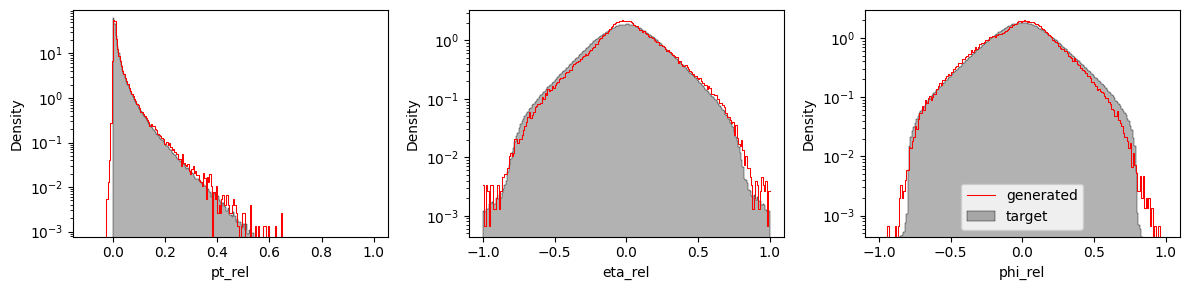

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, figsize=(12,3))

jets_generated.histplot('pt_rel', binrange=(-.1, 1), binwidth=0.005, ax=ax[0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', binrange=(-.1, 1), binwidth=0.005, ax=ax[0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('eta_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('phi_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[2], log_scale=(False, True), color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel',binrange=(-1, 1), binwidth=0.01, ax=ax[2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[2].legend()
plt.tight_layout()
plt.show()

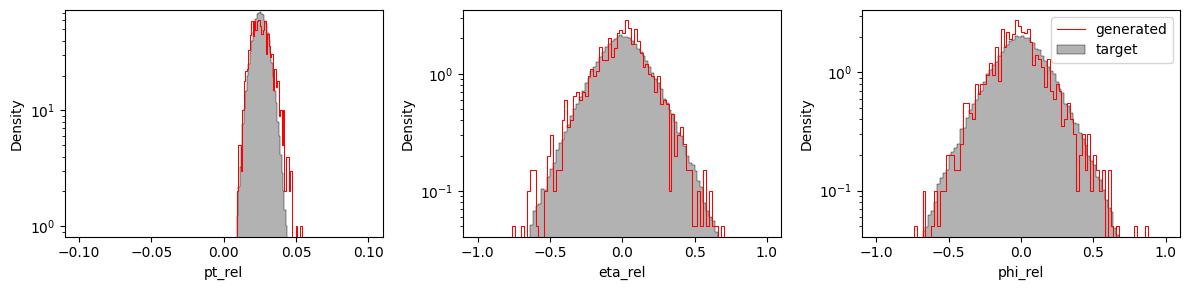

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))

jets_generated.histplot('pt_rel', idx=10, binrange=(-.1, .1), binwidth=0.001, ax=ax[0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', idx=10, binrange=(-.1, .1), binwidth=0.001, ax=ax[0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('eta_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', idx=10,  binrange=(-1, 1), binwidth=0.02, ax=ax[1],  log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('phi_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[2],log_scale=(False, True),  color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[2].legend()
plt.tight_layout()
plt.show()

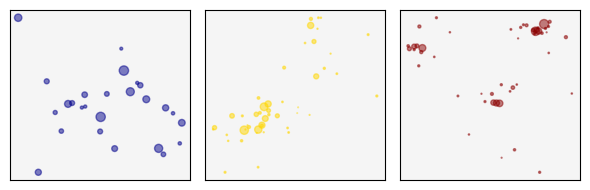

In [40]:
n=102
fig, ax = plt.subplots(1,3, figsize=(6,2))
jets.source.display_cloud(idx=n, scale_marker=100, ax=ax[0], color='darkblue')
jets_generated.display_cloud(idx=n, scale_marker=100, ax=ax[1], color='gold')
jets.target.display_cloud(idx=n, scale_marker=100, ax=ax[2], color='darkred')
plt.tight_layout()
plt.show()